## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.


##### Questions:
1)	Analyze the results of the experiment and identify the effect of the Treatment on product purchase and Net Incremental Revenue
2)	Build a model to select the best customers to target that maximizes the Incremental Response Rate and Net Incremental Revenue. 
##### Deliverables
3)	Score the ‘Test.csv’ using the model and select the best customers and share the customer ID’s as  csv file 
4)	Explain briefly the approach used in a separate document and also share the code that can be executed to reproduce results.

# Notebook 1: EDA
This notebook assesses, cleans and explores data to understand distributions, relationships and patterns.
Can we identify which features best describe customers that will purchase after receiving a promotion?




## Table of contents

- [Data gathering](#data)
- [Assessing](#assessing)
- [Data Cleaning](#cleaning)
- [Exploratory Data Analysis](#EDA)
  - [Univariate exploration](#uni)
  - [Bivariate exploration](#bi)
  - [Multivariate exploration](#multi)
- [Statistical Analysis](#stats)
- [Summary](#summary)



In [1]:
# load in packages
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# custom coding
from src import Seafoam, config, get_mi_score

%matplotlib inline

# font standardization
seafoam = Seafoam()

#suppress warnings
warnings.filterwarnings('ignore')

In [2]:
def fd_optimal_bins(data: np.array) -> int:
    """ The Freedman-Diaconis rule for optimal bin selection
    Parameters: 
        data (np.array) - a one-dimensional array with data
    Returns:
        nbins (int) - number of bins
    """
    assert data.ndim == 1
    n = data.size
    
    p25, p75 = np.percentile(data, [25, 75])

    width = 2. * (p75 - p25)/n**(1./3)
    nbins = np.ceil((data.max() - data.min()) / width)
    nbins = max(1, nbins)
    
    return nbins

<a class="anchor" id=data></a>
## Data Gathering

In [3]:
# load in the data
train_data = pd.read_csv(config.path_train_data)
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


In [4]:
train_data.shape

(84534, 10)

<a class="anchor" id=assessing></a>
## Assessing

In [5]:
# Inspect missing values and data types
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         84534 non-null  int64  
 1   Promotion  84534 non-null  object 
 2   purchase   84534 non-null  int64  
 3   V1         84534 non-null  int64  
 4   V2         84534 non-null  float64
 5   V3         84534 non-null  float64
 6   V4         84534 non-null  int64  
 7   V5         84534 non-null  int64  
 8   V6         84534 non-null  int64  
 9   V7         84534 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [6]:
# inspect descriptive statistics
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [7]:
# Inspect unique records
train_data.nunique()

ID           84534
Promotion        2
purchase         2
V1               4
V2           84518
V3              40
V4               2
V5               4
V6               4
V7               2
dtype: int64

In [8]:
# Get counts for unique values
cols = ['Promotion', 'purchase', 'V1', 'V3', 'V4', 'V5', 'V6', 'V7']
for col in cols:
    print('\n')
    print(train_data[col].value_counts())



Promotion
Yes    42364
No     42170
Name: count, dtype: int64


purchase
0    83494
1     1040
Name: count, dtype: int64


V1
1    31631
2    31608
3    10670
0    10625
Name: count, dtype: int64


V3
 1.085939    2221
-1.165083    2208
-0.299306    2188
-1.424817    2171
 1.605406    2163
 1.518828    2156
-0.905350    2153
-1.338239    2140
-0.991928    2140
-1.684550    2139
 0.393317    2136
 0.047006    2133
 0.826206    2133
-1.597972    2131
-0.645617    2122
 0.306739    2118
-0.732194    2116
 0.566472    2115
 0.479895    2111
-0.212728    2111
-1.251661    2101
 0.739628    2101
-1.078506    2100
-0.385883    2100
 0.912784    2100
-0.039572    2099
 1.259095    2095
-0.126150    2087
 0.999361    2085
 1.345672    2084
-0.818772    2083
 0.653050    2080
-0.472461    2072
 0.220161    2072
-0.559039    2070
-1.511395    2064
 1.432250    2063
 1.172517    2060
 1.691984    2059
 0.133583    2054
Name: count, dtype: int64


V4
2    57450
1    27084
Name: count, dtype: int6

In [9]:
# check for duplicated lines
train_data.duplicated().sum()

0

### Summary of assessment

Overall data is very clean, there are no missing or duplicated values.
 
The following data cleaning steps are needed to prepare data for EDA.

1. Column Promotion is a boolean field that contains values 'Yes' or 'No'
2. Continues features V3 was normalized using a standard scaler type technique as mean is 0 and std is 1, whilst V2 was not.
3. Drop unneeded variables like 'ID'
4. Feature engineering: Split data into control and treatment groups to compare features

<a class="anchor" id=cleaning></a>
## Data Cleaning

In [10]:
#  Make a copy of the data
train_data_clean = train_data.copy(deep=True)

##### 1. Convert 'Promotion' to a binary field to support EDA

In [11]:
# values before conversion
train_data_clean['Promotion'].value_counts()

Promotion
Yes    42364
No     42170
Name: count, dtype: int64

In [12]:
le = LabelEncoder()
train_data_clean['Promotion'] = le.fit_transform(train_data_clean['Promotion'])

# values after conversion
train_data_clean['Promotion'].value_counts()

Promotion
1    42364
0    42170
Name: count, dtype: int64

##### 2. Use standard scaler on V2 to compare with V3 more effectively.

In [13]:
scaler = StandardScaler()
train_data_clean['V2_scaled'] = scaler.fit_transform(train_data_clean[['V2']])
train_data_clean['V2_scaled'].describe()

count    8.453400e+04
mean    -3.002412e-16
std      1.000006e+00
min     -4.564245e+00
25%     -6.749893e-01
50%      1.226168e-03
75%      6.727727e-01
max      4.071833e+00
Name: V2_scaled, dtype: float64

##### 3. Drop ID column

In [14]:
## Make ID the index the remove it
train_data_clean.drop('ID', axis=1, inplace=True, errors='ignore')
train_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Promotion  84534 non-null  int64  
 1   purchase   84534 non-null  int64  
 2   V1         84534 non-null  int64  
 3   V2         84534 non-null  float64
 4   V3         84534 non-null  float64
 5   V4         84534 non-null  int64  
 6   V5         84534 non-null  int64  
 7   V6         84534 non-null  int64  
 8   V7         84534 non-null  int64  
 9   V2_scaled  84534 non-null  float64
dtypes: float64(3), int64(7)
memory usage: 6.4 MB


##### 4. Feature engineering: Split data into control and treatment groups to compare features

In [15]:
# Split data into control and treatment groups
control_group = train_data_clean.query('Promotion == 0')
treatment_group = train_data_clean.query('Promotion == 1')

# drop promotion from treatment and control datasets as it's the split criteria
treatment_group = treatment_group.drop('Promotion', axis=1, errors='ignore')
control_group = control_group.drop('Promotion', axis=1, errors='ignore')
treatment_group.head()

,purchase,V1,V2,V3,V4,V5,V6,V7,V2_scaled
4,0,3,28.044331,-0.385883,1,1,2,2,-0.385038
8,0,2,31.930423,0.393317,2,3,1,2,0.390537
10,0,1,32.770916,-1.511395,2,1,4,1,0.558280
12,0,1,36.957009,0.133583,2,3,1,1,1.393728
14,0,3,36.911714,-0.905350,2,2,4,1,1.384688


<a class="anchor" id=EDA></a>
## Exploratory Data Analysis

In [16]:
# feature engineering
# Split data into control and treatment groups
control_group = train_data_clean.query('Promotion == 0')
treatment_group = train_data_clean.query('Promotion == 1')

# drop promotion from treatment and control datasets as it's the split criteria
treatment_group = treatment_group.drop('Promotion', axis=1, errors='ignore')
control_group = control_group.drop('Promotion', axis=1, errors='ignore')
treatment_group.head()

,purchase,V1,V2,V3,V4,V5,V6,V7,V2_scaled
4,0,3,28.044331,-0.385883,1,1,2,2,-0.385038
8,0,2,31.930423,0.393317,2,3,1,2,0.390537
10,0,1,32.770916,-1.511395,2,1,4,1,0.558280
12,0,1,36.957009,0.133583,2,3,1,1,1.393728
14,0,3,36.911714,-0.905350,2,2,4,1,1.384688


<a class="anchor" id=uni></a>
### Univariate Exploration

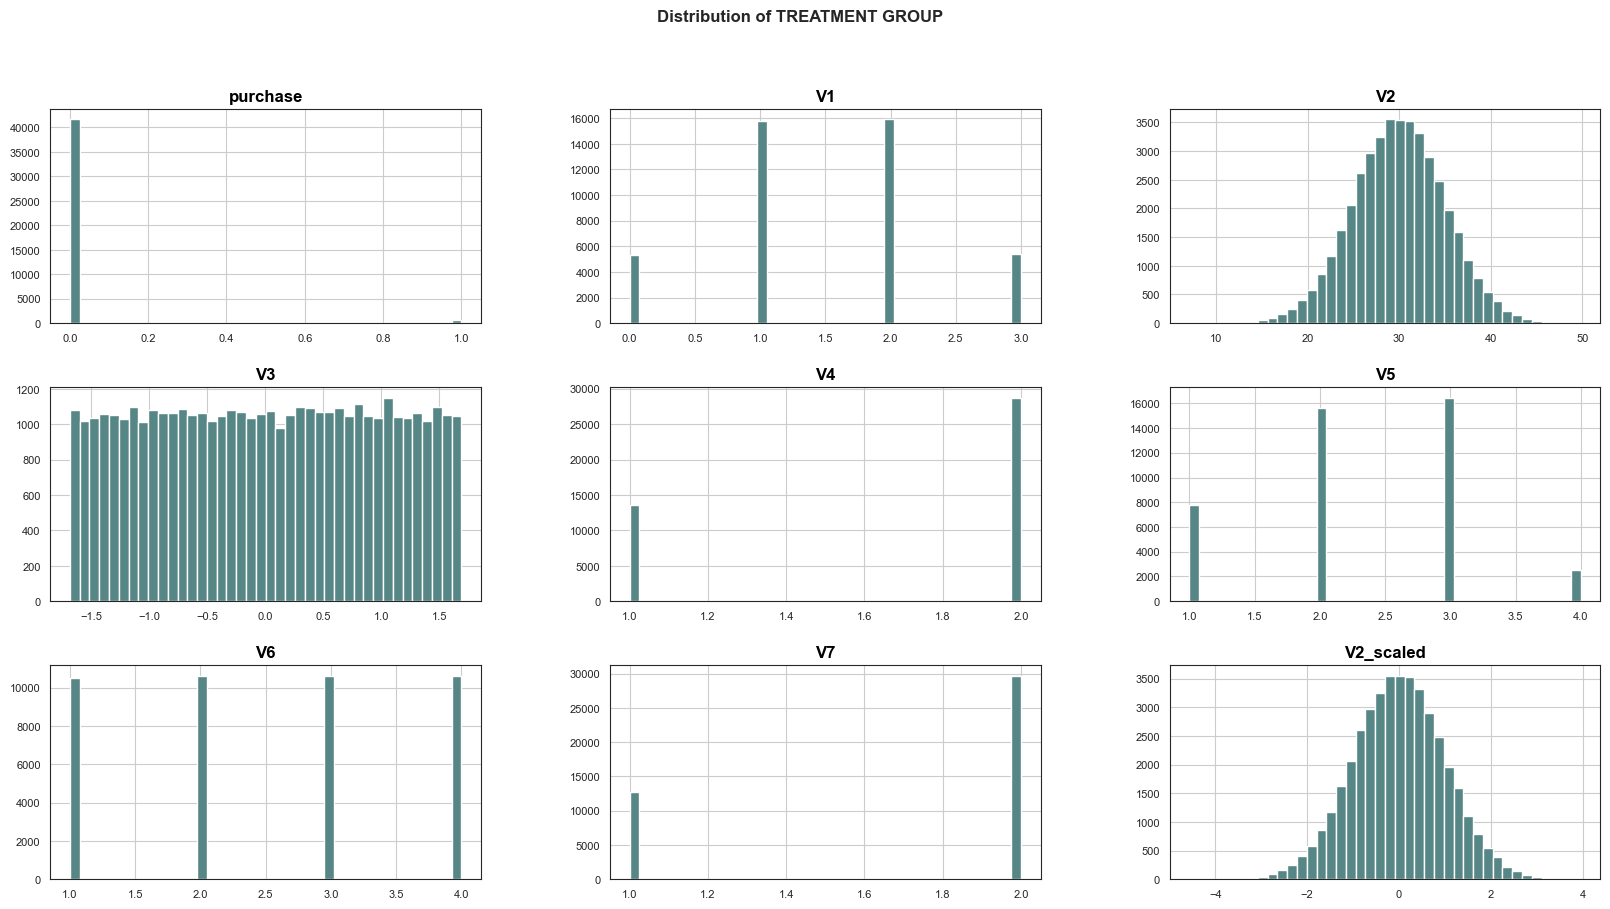

In [17]:
# get a general first idea of numeric feature distributions for the TREATMENT group
pd.plotting.hist_frame(treatment_group, figsize=(20,10), bins=40, color=seafoam.base_color_group1)
plt.suptitle("Distribution of TREATMENT GROUP")
plt.show()

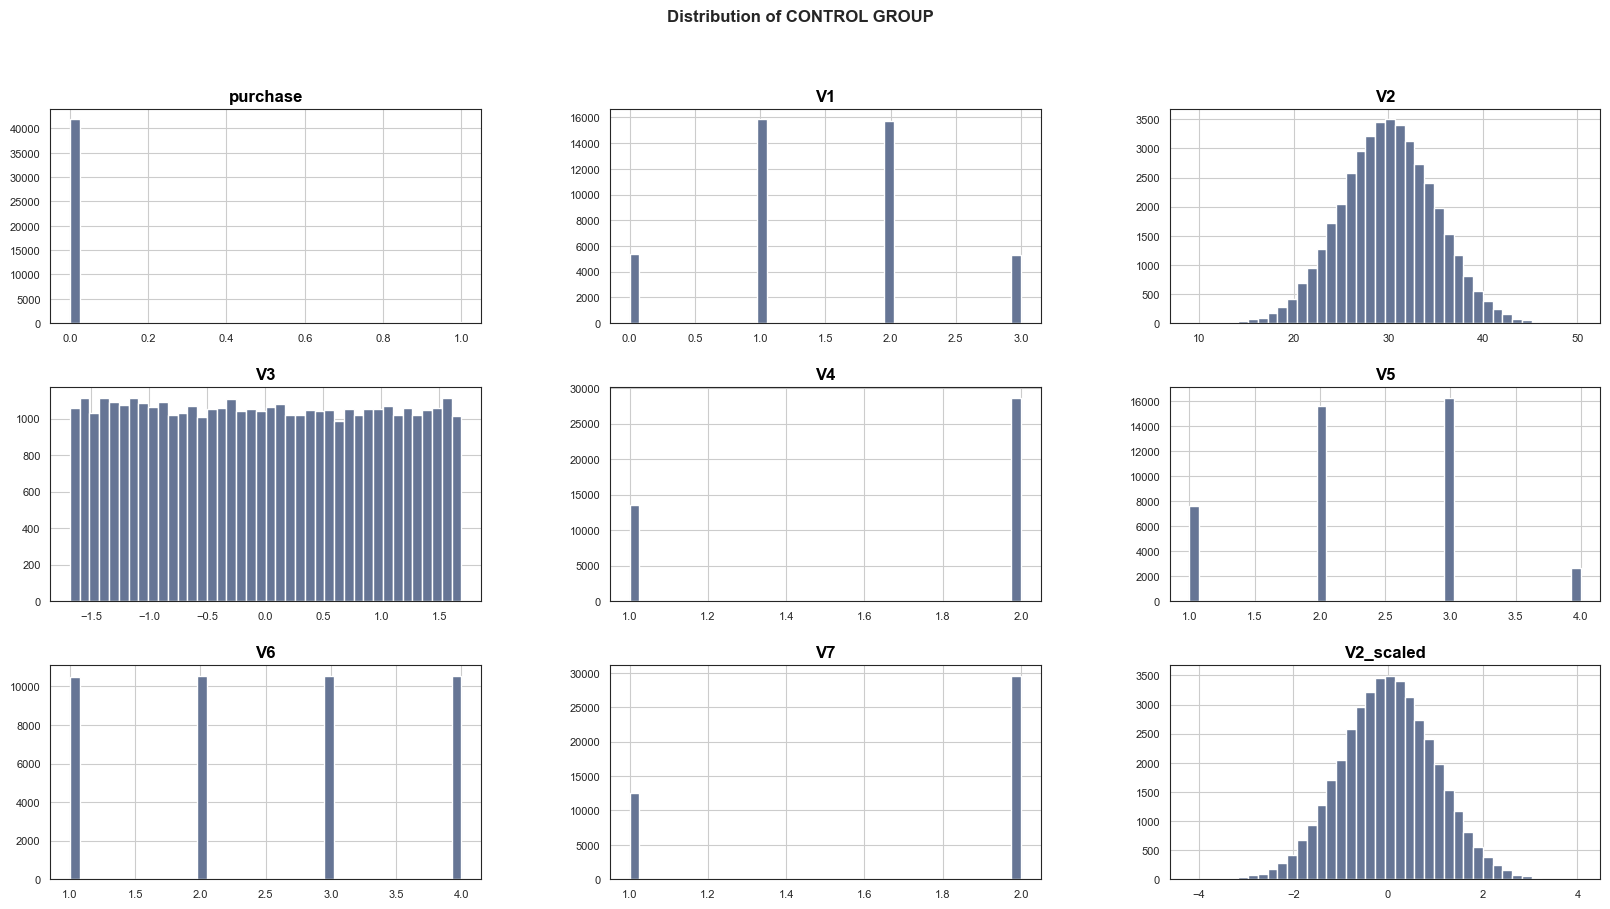

In [18]:
# get a general first idea of numeric feature distributions for the CONTROL group
pd.plotting.hist_frame(control_group, figsize=(20,10), bins=40, color=seafoam.base_color_group2)
plt.suptitle("Distribution of CONTROL GROUP")
plt.show()

> Observations: 
> 
> - By visual inspection, the distribution of features V1-V7 appears to be the same for control and treatment groups
> - V2 and V3 are continues variables. V2 have normal distribution, V3 have uniform distribution
> - The Rest of the fields appear to be categorical, however it's not possible to tell if the anonymous data is ordinal

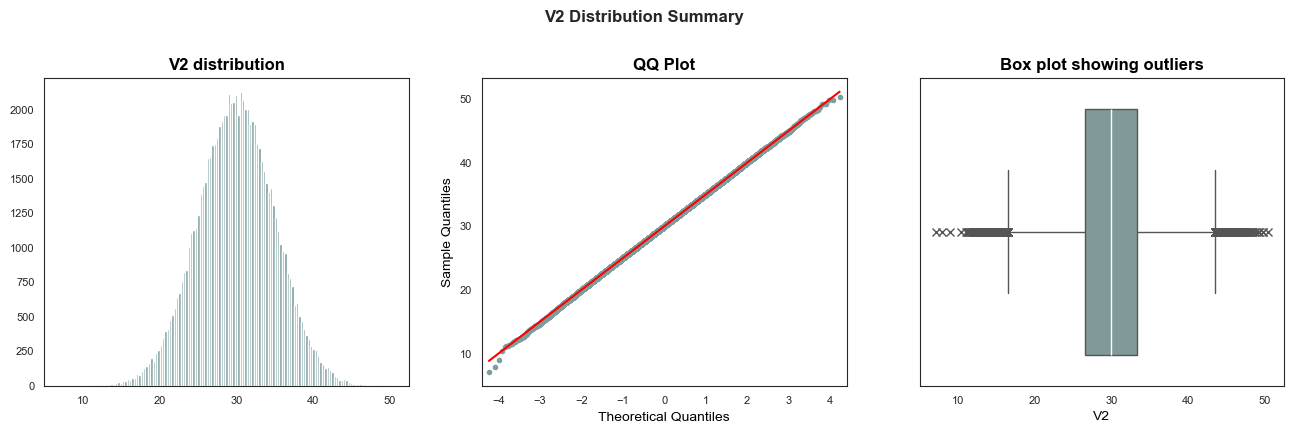

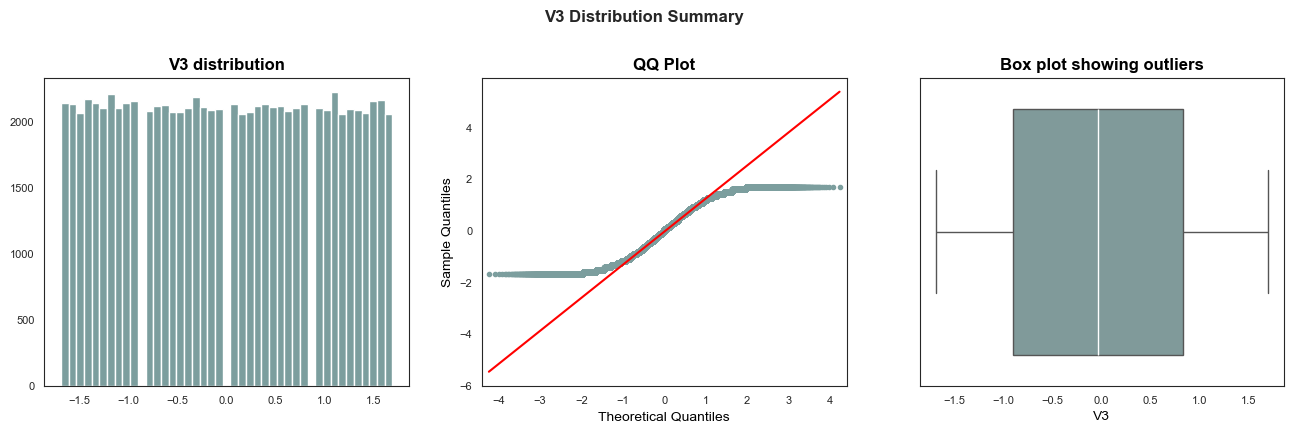

In [19]:
# 2 fields are continues numerical values, lets deeper investigate them
for col in ['V2', 'V3']:
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    bin_size = fd_optimal_bins(train_data_clean[col])
    # bins = np.arange(train_data_clean[col].min() - bin_size, train_data_clean[col].max() + bin_size, bin_size)
    plt.hist(x=train_data_clean[col], bins=int(bin_size), color=seafoam.base_color)
    plt.title('{} distribution'.format(col))
    
    ax = plt.subplot(1, 3, 2)
    sm.qqplot(data=train_data_clean[col],
                       line='q',
                       ax=ax,
                       marker='.',
                       markerfacecolor=seafoam.base_color,
                       markeredgecolor=seafoam.base_color,
              )
    plt.title('QQ Plot')
    
    plt.subplot(1, 3, 3)
    sns.boxplot(data=train_data_clean, x=col, color=seafoam.base_color,
                flierprops={"marker": "x"},
                medianprops={"color": 'white'},
                )
    plt.title('Box plot showing outliers')
    
    plt.suptitle('{} Distribution Summary'.format(col), y=1.05)
    plt.show()

>Observations: 
> - V2 have some minor outliers < 10 and > 50 

<a class="anchor" id=bi></a>
### Bivariate Exploration

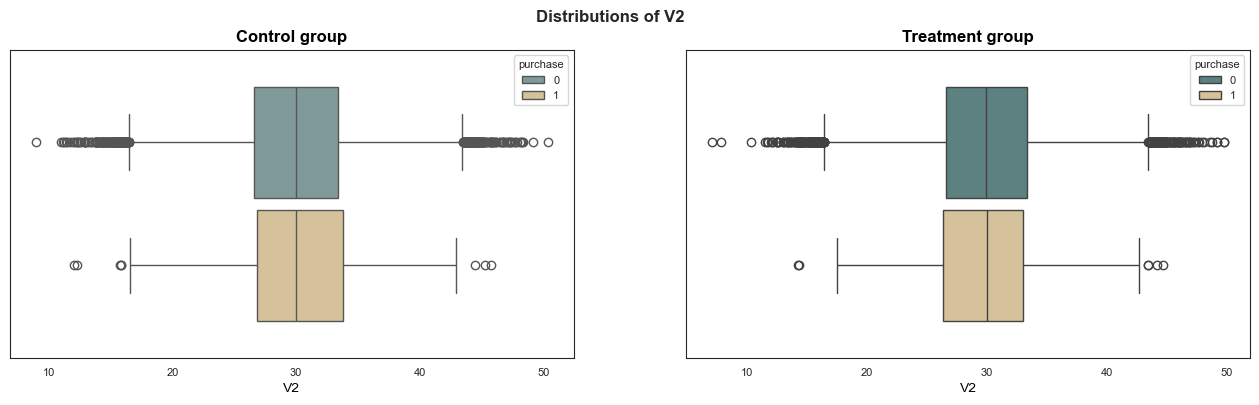

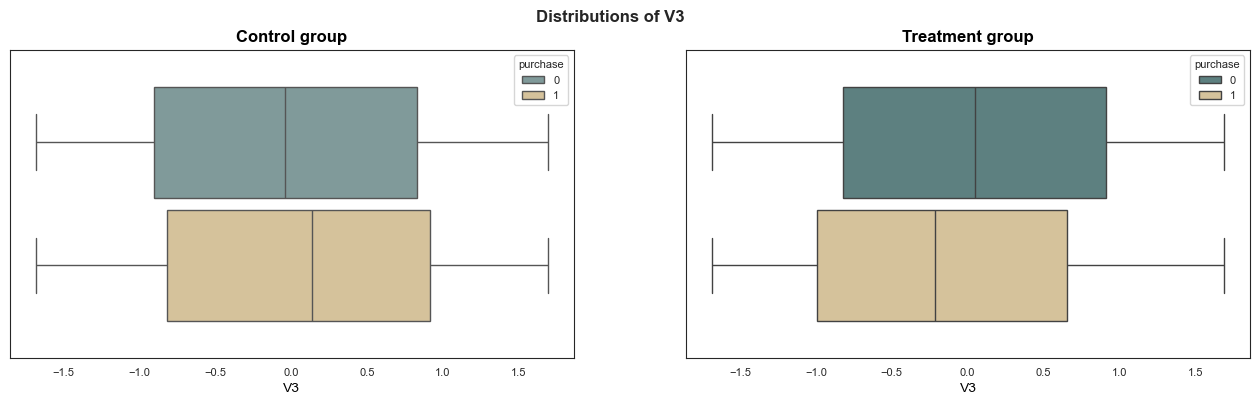

In [20]:
# Inspect differences in purchasing behavior between control and treatment groups
for col in ['V2', 'V3']:
    fig, ax = plt.subplots(ncols=2, figsize=(16, 4))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(data=control_group,
                x=col,
                hue='purchase',
                dodge=True,
                gap=0.1,
                palette=(seafoam.base_color, seafoam.base_complimentary),
                )
    plt.title('Control group')
    plt.xlabel(col)
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data=treatment_group,
                x=col,
                hue='purchase',
                dodge=True,
                gap=0.1,
                palette=(seafoam.base_color_group1, seafoam.base_complimentary),
                )
    plt.title('Treatment group')
    
    plt.suptitle('Distributions of {}'.format(col))
    plt.show()

>Observations for V2: (Normally distributed feature)
> - Control group has a slightly wider range between **Q2 and Q3 quantiles** for customers who purchased the product without promotion
> - Treatment group has a slightly wider range between **Q1 and Q2 quantiles** for customers who purchased with product with a promotion



>Observations for V3: (Uniformly distributed feature already standardized)
> - Control group has a **higher mean** for customers who purchased the product without promotion
> - Treatment group has a **lower mean** customers who purchased the product with a promotion
> - The IQR of the treatment group are shifted slightly the left of the mean

> It thus looks like those who bought the product after receiving the promotion have a below mean average. e.g., if this feature was for example income, it means the treatment group who purchases are of lower income groups.

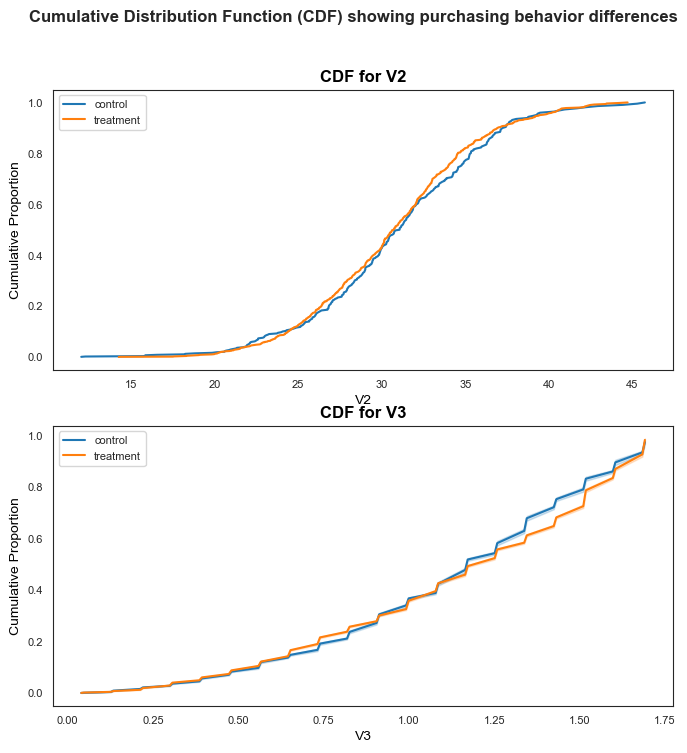

In [21]:
# PLOT cdf to plot the differences in distribution in purchasing behavior between the 2 groups
fig, ax = plt.subplots(nrows=2, figsize=(8, 8))
i = 1
for col in ['V2', 'V3']:
    plt.subplot(2, 1, i)
    cpur = control_group[control_group['purchase'] == 1][col]
    tpur = treatment_group[treatment_group['purchase'] == 1][col] 
    c_sorted = np.sort(abs(cpur))
    ccum = np.cumsum(c_sorted / np.sum(c_sorted))
    t_sorted = np.sort(abs(tpur))
    tcum = np.cumsum(t_sorted / np.sum(t_sorted))
    sns.lineplot(x=c_sorted, y=ccum, label='control')
    sns.lineplot(x=t_sorted, y=tcum, label='treatment')
    plt.title('CDF for {}'.format(col))
    plt.xlabel(col)
    plt.ylabel('Cumulative Proportion')
    i += 1
    
plt.suptitle('Cumulative Distribution Function (CDF) showing purchasing behavior differences')
plt.show()

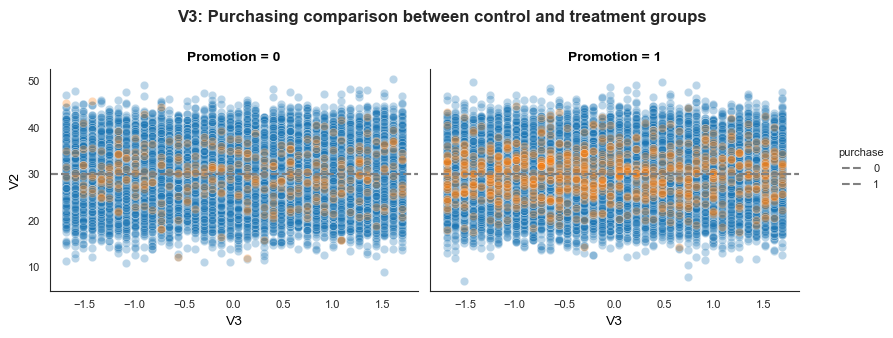

In [22]:
# V2 / V3 relationship - deeper dive 
g = sns.FacetGrid(data=train_data_clean, hue='purchase', col='Promotion', margin_titles=True, height=3, aspect=1.4) 
g.map(sns.scatterplot, 'V3', 'V2', alpha=0.3, sizes=2)
g.refline(y=train_data_clean["V2"].mean())
g.add_legend()
g.set_titles('1', '2')
plt.suptitle('V3: Purchasing comparison between control and treatment groups', y=1.1)
plt.show()


> **Observation**:
For the treatment group with a promotion on the right graph, more purchases are centered around the mean, with higher intensity below mean of 0.

<Figure size 2000x2000 with 0 Axes>

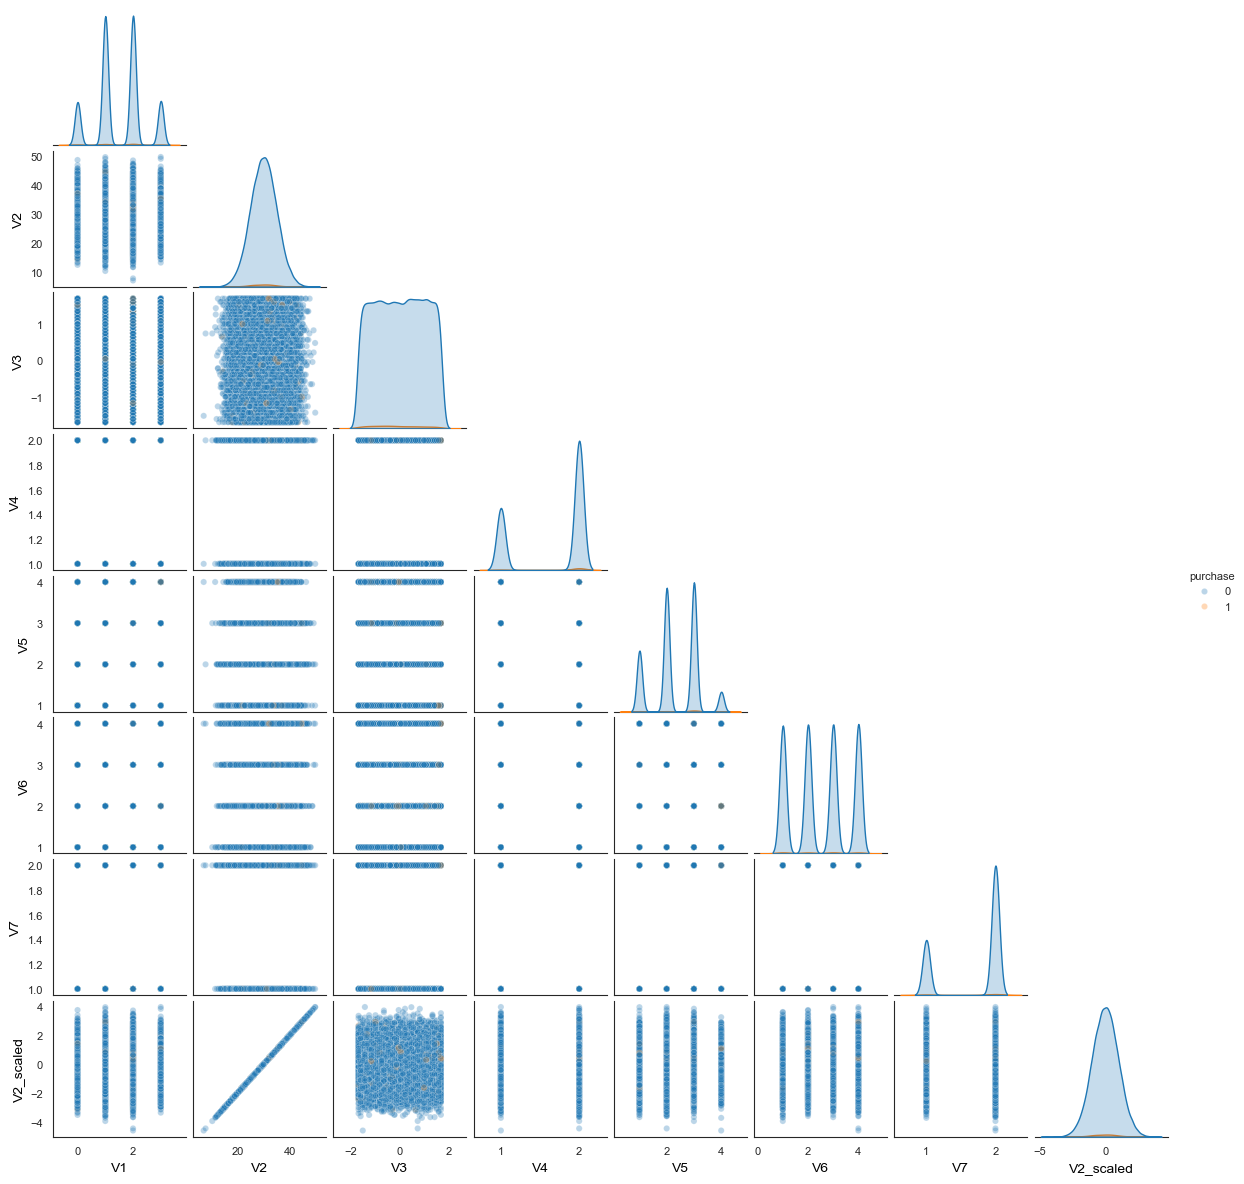

In [23]:
# Analyze the correlation between numeric variables
plt.figure(figsize=(20,20))
sns.pairplot(treatment_group, 
             diag_kind='auto',
             hue="purchase", 
             hue_order=[0, 1],
             corner=True, 
             height=1.5,
             plot_kws={"s": 20, "alpha": 0.3},
             )
plt.show()

>Observation:
In cases with high imbalance like in this project, this kind of plot reveals little information. <br>
No linear relationships or interesting patterns are revealed.

#### Correlation analysis
- Make sure independent variables does not have too high correlations with each other

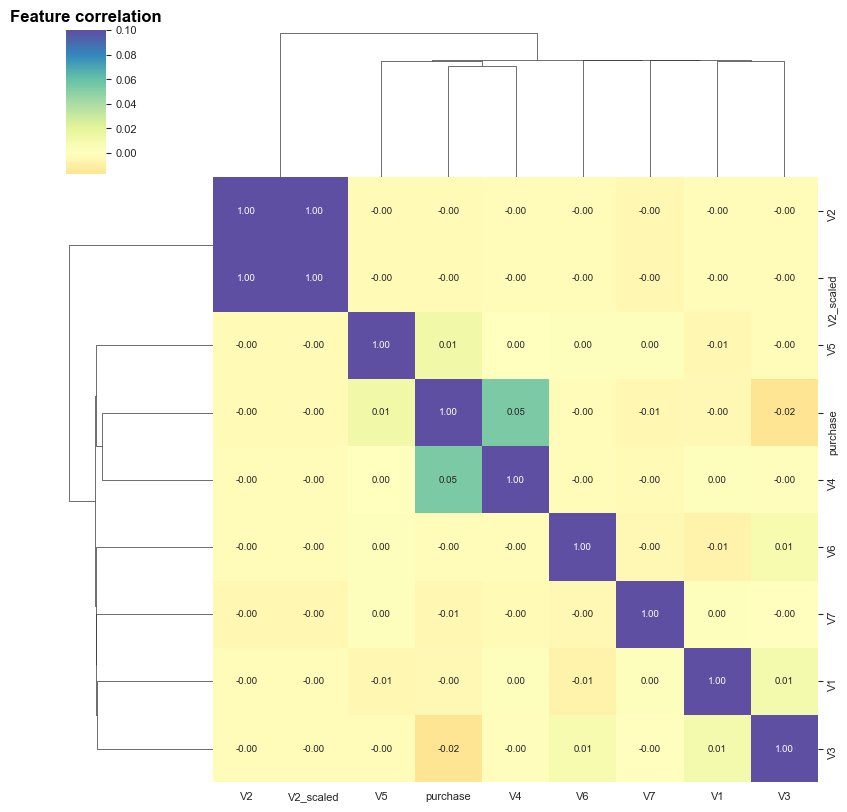

In [24]:
df_corr = treatment_group.corr(
    method='pearson',
    numeric_only=True,
    min_periods=1)

sns.clustermap(df_corr,
               cmap="Spectral",
               center=0,
               annot=True,
               fmt='.2f',
               vmax=0.1,
               annot_kws={"fontsize": 7},
               figsize=(8,8))

plt.title('Feature correlation')
plt.xticks(fontsize=10)
plt.show()

sns.set_style("white")

> **Observation:** In treatment group, 'purchase' have the strongest correlations with V3, V4 and V5, although they are not superstrong.

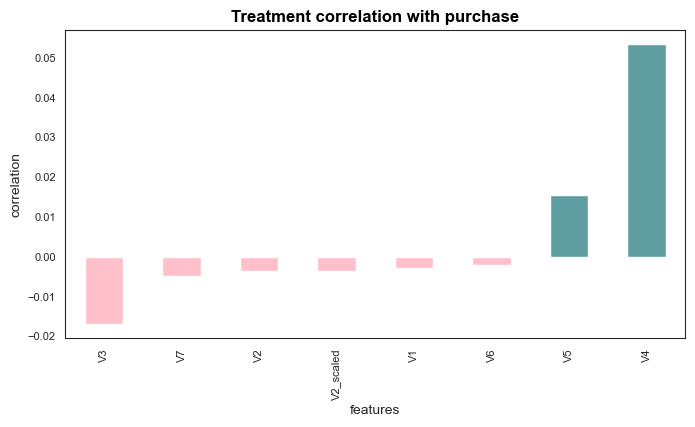

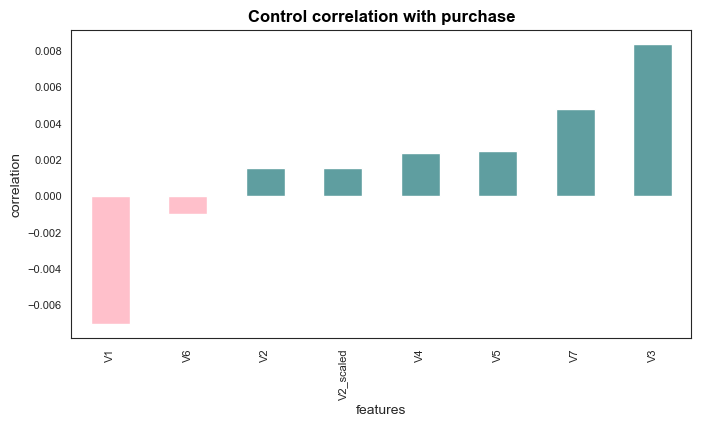

In [25]:
#  Get the strongest correlation of features with those who made a purchase
dfs = [treatment_group, control_group]
dfs_names = ['Treatment', 'Control']
i = 0
for df in dfs:
    cols = list(df.columns)
    cols.remove('purchase')
    
    corr_matrix = df[cols].corrwith(df["purchase"],
                                    method='spearman').sort_values()
    
    # Plot feature correlations to no_show
    palette = sns.color_palette("viridis_r", 15)
    pos = 'cadetblue'
    neg = 'pink'
    corr_matrix.plot(
        kind='bar',
        color=np.vectorize({True: pos, False: neg}.get)(corr_matrix > 0))
    
    plt.xticks(rotation='vertical')
    plt.ylabel('correlation')
    plt.xlabel('features')
    plt.title('{} correlation with purchase'.format(dfs_names[i]))
    i =+ 1
    plt.show()
    

> **Observations**: <br>
> Treatment group: Once again we see features V4, V5 and V3 have the strongest correlation with purchase.
<br>
> Control group: 
> Features V3, V7 and V1 have the strongest correlation with purchase however the correlations are much weaker than in treatment group.

<a class="anchor" id=multi></a>
### Multivariate Exploration

We discovered during bivariate exploration that different features control the purchasing behaviour in control and treatment groups.
For treatment groups, features V3, V4 and V5 have the strongest correlations with purchase
For control group, features V3, V7 and V1 have the strongest correlations with purchase

Let's deep dive into these features, comparing control and treatment groups with each other.

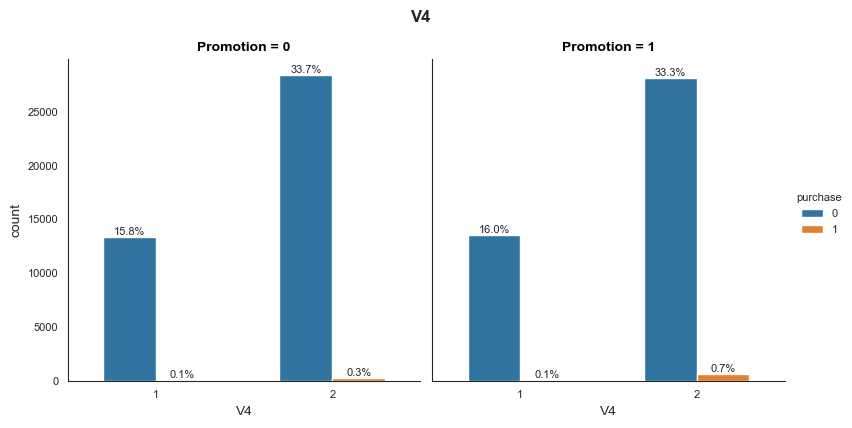

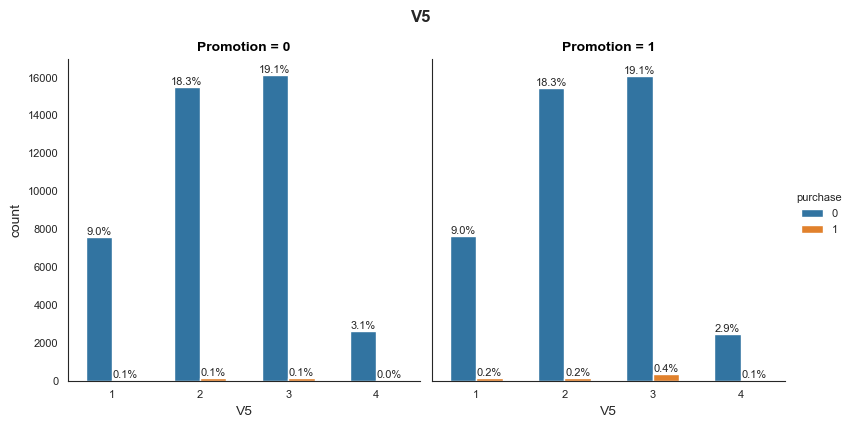

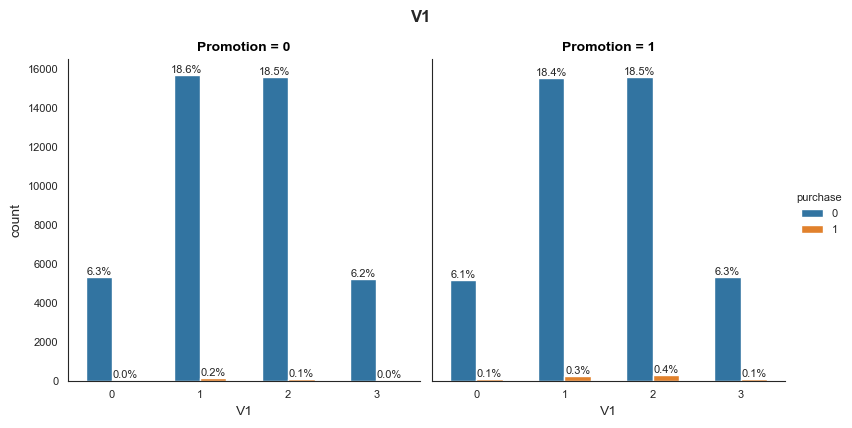

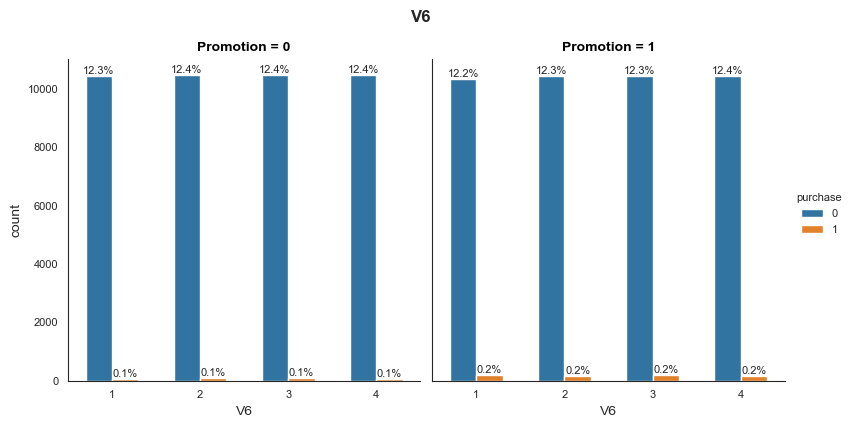

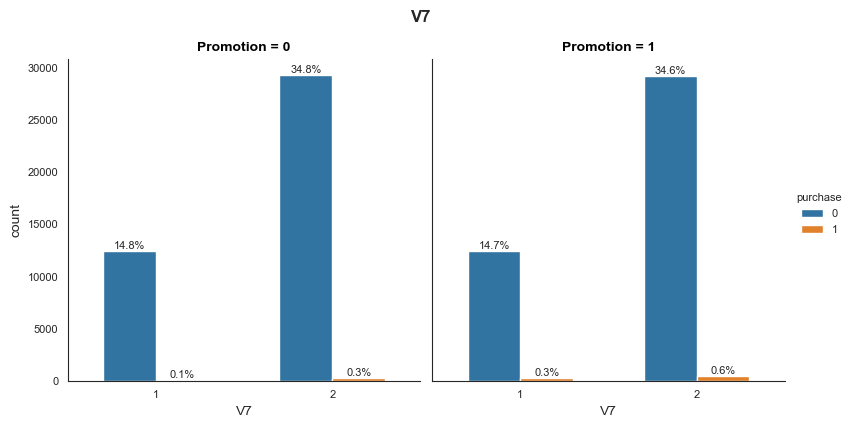

In [26]:
cols_of_interest = ['V4', 'V5', 'V1', 'V6', 'V7']
for col in cols_of_interest:
    g = sns.catplot(data=train_data_clean, x=col, col='Promotion', hue='purchase', kind='count',
                height=4, aspect=1, width=0.6) 
    # g.despine(left=True)
    plt.suptitle(col, y=1.05)
    
    # annotate bars by iterating through each Facet (axes)
    for ax in g.axes.ravel():
        # iterate through the containers (bars)        
        for bars in ax.containers:
            labels = [f"{x/train_data_clean.shape[0]:.1%}" for x in bars.datavalues]
            ax.bar_label(bars, labels)
    
    plt.show()

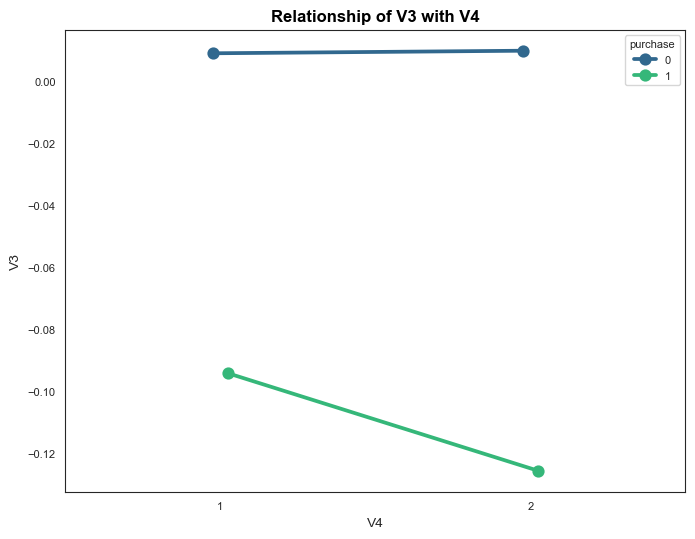

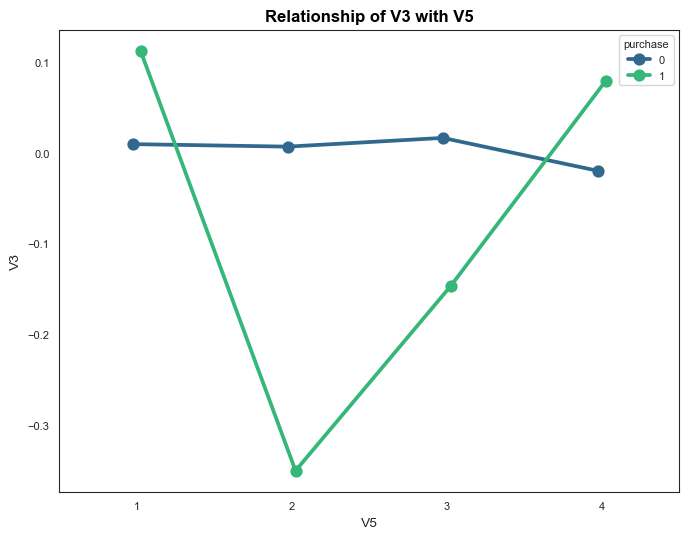

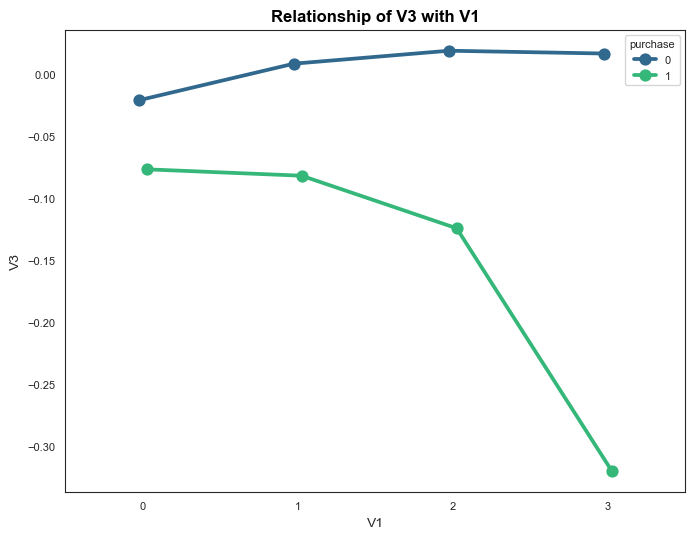

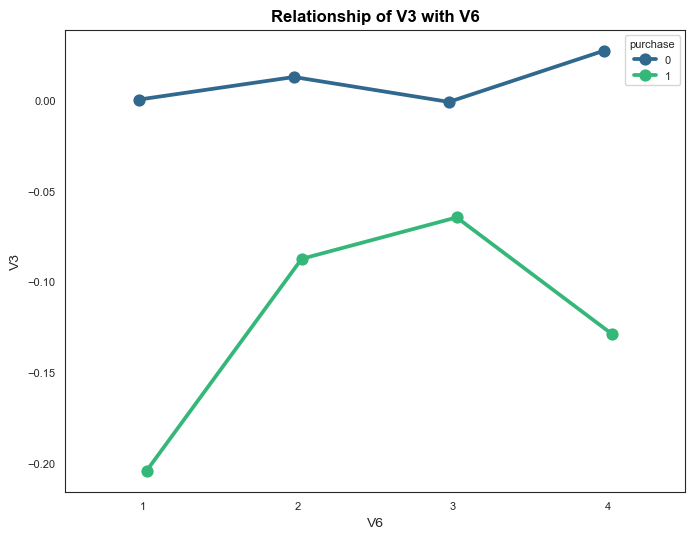

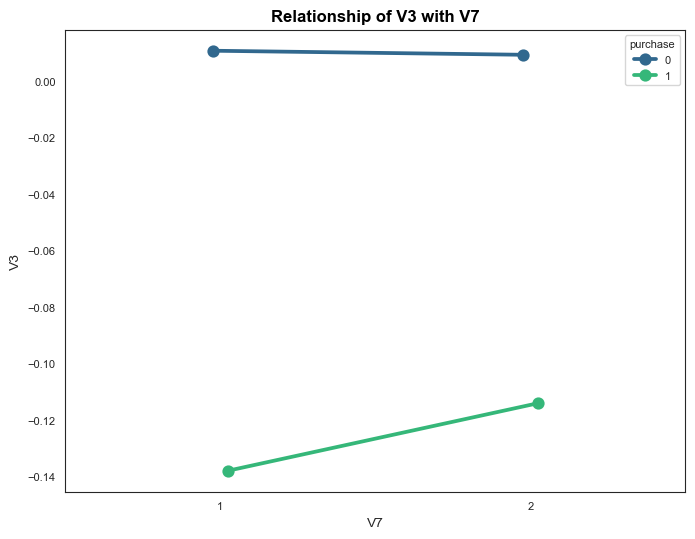

In [27]:
for col in ['V4', 'V5', 'V1', 'V6', 'V7']:
    plt.figure(figsize = [8,6])
    sns.pointplot(data = treatment_group, x=col, y='V3', hue = 'purchase',  palette='viridis', 
                       errorbar=None,
                       dodge=True)
    plt.title('Relationship of V3 with {}'.format(col))
    plt.show()

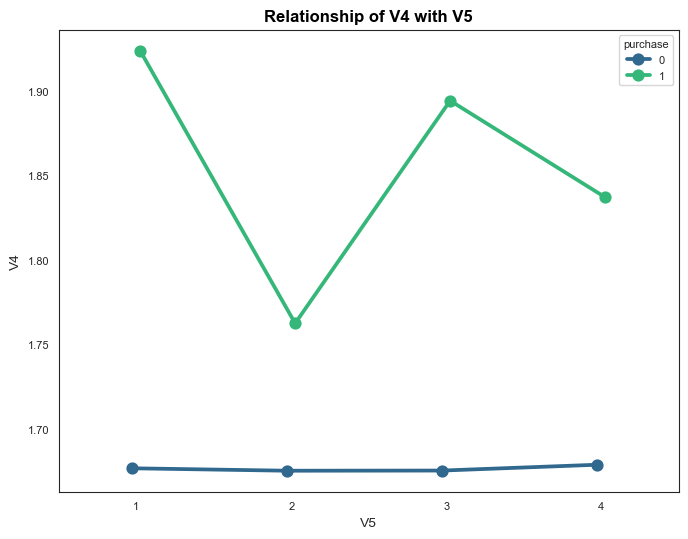

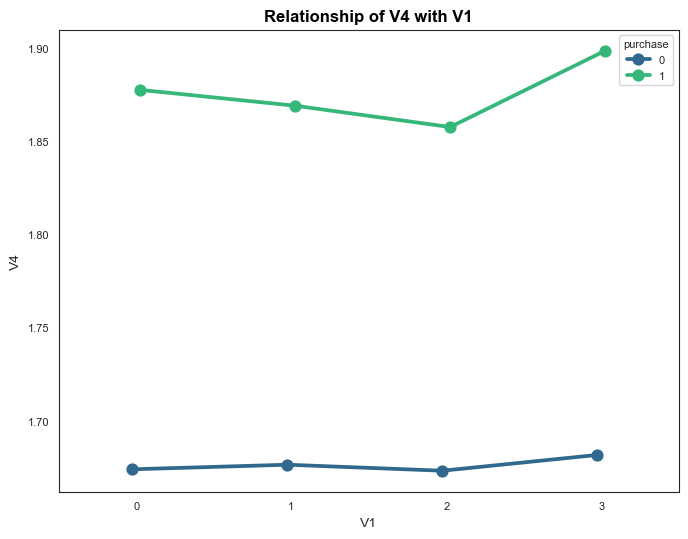

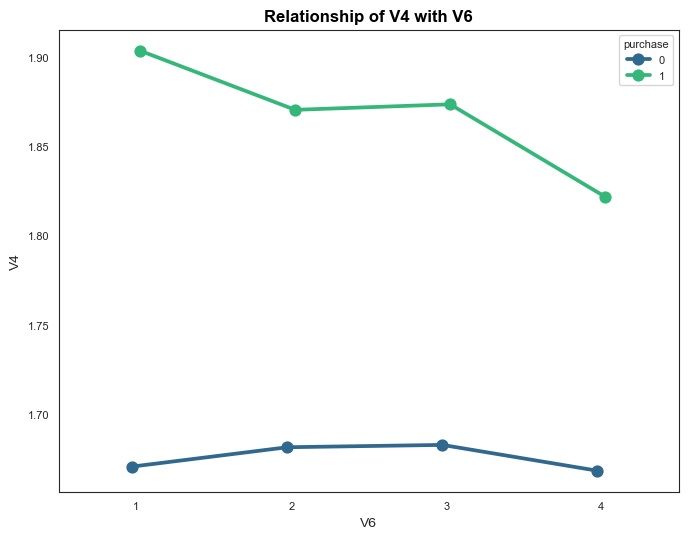

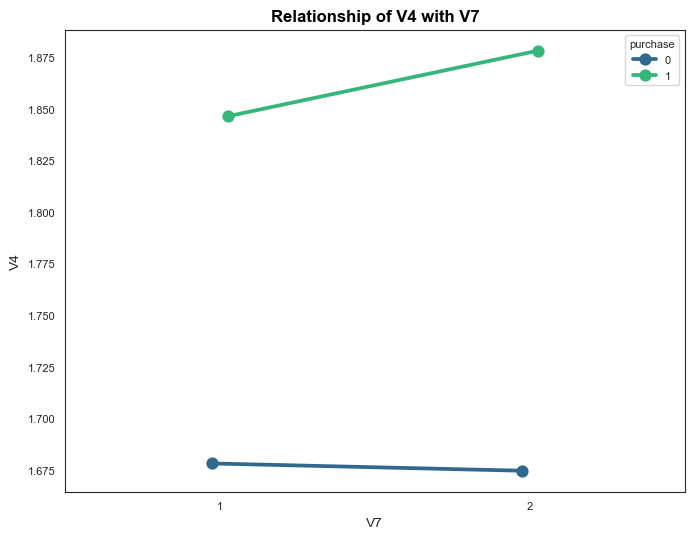

In [28]:
for col in ['V5', 'V1', 'V6', 'V7']:
    plt.figure(figsize = [8,6])
    sns.pointplot(data = treatment_group, x=col, y='V4', hue = 'purchase',  palette='viridis', 
                       errorbar=None,
                       dodge=True)
    plt.title('Relationship of V4 with {}'.format(col))
    plt.show()

> **Observation**:
- All categorical features V1, V4, V5, V6, V7 show higher purchases in the treatment group compared to the control group, although purchases also appear in control group. 
- Point plots between categorical features and V3 always clearly separate purchases with a purchases occurring when V3 is negative.
- Point plots between categorical features and V4 always clearly separate purchases with a purchases occurring when V4 = 2.
- V3 and V4 are by far the most important features, when values are positive, no purchases occur. 

<a class="anchor" id=stats></a>
## Statistical Analysis

#### Mutual Information (MI) - Feature Importance

Mutual Information (MI) is a way to show how every feature interact with the target variable in this case 'purchase'. To interact means how a particular feature changes the target variable. Note: Mutual Information only works with numerical data

A higher value of MI means a closer connection between the feature and the target indicating feature importance for training the model. However, the lower the MI score like 0 indicates a weak connection between the feature and the target.

In [29]:
df_stats = train_data.copy()

scaler = StandardScaler()
df_stats['V2'] = scaler.fit_transform(df_stats[['V2']])

df_stats.set_index('ID', inplace=True, verify_integrity=True)

# filter dataset to use only the treatment group which received the promotions
df_stats = df_stats[(df_stats['Promotion'] == 'Yes')]

df_stats.drop(['Promotion'], axis=1, inplace=True, errors='ignore')
df_stats.head()

,purchase,V1,V2,V3,V4,V5,V6,V7
ID,,,,,,,,
8,0,3,-0.385038,-0.385883,1,1,2,2
15,0,2,0.390537,0.393317,2,3,1,2
17,0,1,0.558280,-1.511395,2,1,4,1
20,0,1,1.393728,0.133583,2,3,1,1
22,0,3,1.384688,-0.905350,2,2,4,1


In [30]:
stats_cols = list(df_stats.columns)
stats_cols.remove('purchase')
print(stats_cols)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']


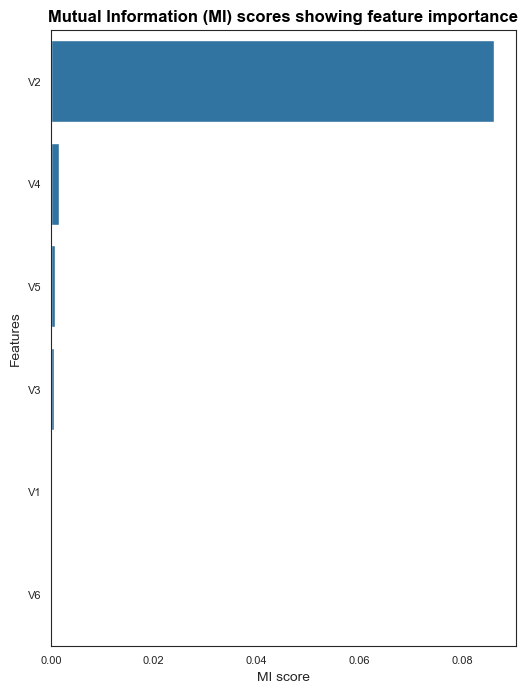

In [31]:
mi_score = get_mi_score(df_stats[stats_cols], df_stats['purchase'])

# Show most important features
topn = 6
plt.figure(figsize=(6, 8))
ax = sns.barplot(y=mi_score.index[:topn], x=mi_score[:topn])
plt.xlabel('MI score')
plt.ylabel('Features')
ax.set_title('Mutual Information (MI) scores showing feature importance')
plt.show()

#### Test for multicollinearity using Variance Inflation Factor (VIF)

Multicollinearity means, there are linear relationships or correlation between independent variables, which should not be the case for linear regression to be effective.

Typically, a variable with VIF greater than 5 indicates Multicollinearity.

In [32]:
vip_features = " + ".join(df_stats[stats_cols])
vip_features

'V1 + V2 + V3 + V4 + V5 + V6 + V7'

In [33]:
sm_y, sm_X = dmatrices('purchase ~' + vip_features,
                       df_stats,
                       return_type='dataframe')
vif = pd.DataFrame()
vif['VIF Factor'] = \
    [variance_inflation_factor(sm_X.values, i) for i in range(sm_X.shape[1])]
vif['features'] = sm_X.columns
vif

,VIF Factor,features
0,43.593194,Intercept
1,1.000188,V1
2,1.000056,V2
3,1.000163,V3
4,1.000023,V4
5,1.000051,V5
6,1.000156,V6
7,1.000060,V7


> **Observation**: VIF factors are all < 5, means there are no relationships between independent variables

#### Analyse logistics regression coeficients to get more clues on feature importance

In [34]:
df_stats['intercept'] = 1
stats_cols.append('intercept')

In [35]:
lm = sm.Logit(df_stats['purchase'], df_stats[stats_cols])
results = lm.fit(cov_type="hc1")
results.summary()

Optimization terminated successfully.
         Current function value: 0.084298
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               purchase   No. Observations:                42364
Model:                          Logit   Df Residuals:                    42356
Method:                           MLE   Df Model:                            7
Date:                Fri, 24 Jan 2025   Pseudo R-squ.:                 0.02207
Time:                        18:53:15   Log-Likelihood:                -3571.2
converged:                       True   LL-Null:                       -3651.8
Covariance Type:                  hc1   LLR p-value:                 1.827e-31
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
V1            -0.0403      0.042     -0.957      0.339      -0.123       0.042
V2            -0.0216      0.038     -0.573      0.566      -0.095       0.052
V3            -0.1321      0.037     -3.523      0.000      -0.206      -0.059
V4             1.1516      0.111     10.410      0.000       0.935       1.368
V5             0.1082      0.048      2.258      0.024       0.014       0.202
V6            -0.0134      0.034     -0.394      0.693      -0.080       0.053
V7            -0.0816      0.081     -1.009      0.313      -0.240       0.077
intercept     -6.1402      0.301    -20.410      0.000      -6.730      -5.551
==============================================================================
"""

> **Observation**:
It is confirmed:
- feature V4 and V5 have a positive effect on purchases, whilst V3 have a negative effect on purchases
- feature V1, V2, V6, V7 have p-values > 0.05, thus are not good choices for prediction

<a class="anchor" id=summary></a>
# Summary
- Features V3, V4, V5 are the most important features to be used in modelling to best identify customers that react to promotions.